*Contents*
===

- [Resampling](#Resampling)
    - [Exercise 2.1](#Exercise-2.1)
- [Rolling windows](#Rolling-windows)
    - [Exercise 2.2](#Exercise-2.2)
- [Trends](#Trends)
    - [Exercise 2.3](#Exercise-2.3)
    - [Linear, quadratic and exponential trend](#Linear,-quadratic-and-exponential-trend) 
- [Decomposition](#Decomposition)
    - [Additive model](#Additive-model)
    - [*seasonal_decompose*](#seasonal_decompose)
- [Forecast](#Forecast)
    - [Facebook Prophet](#Facebook-Prophet)
    - [Exercise 2.4](#Exercise-2.4)
- [Going deeper](#Going-deeper)

In the first lesson we have seen examples of data manipulation and visualization with Pandas, Matplotlib and Seaborn. We have used these tools to analise the seasonality of a time series.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [3]:
df = pd.read_csv('../data/OPSD_Germany_all.csv',
                 parse_dates=True,
                 index_col='Date')

df['Weekday'] = df.index.day_name()

df.head()

,Consumption,Wind,Solar,Weekday
Date,,,,
2006-01-01,1069.184,NaN,NaN,Sunday
2006-01-02,1380.521,NaN,NaN,Monday
2006-01-03,1442.533,NaN,NaN,Tuesday
2006-01-04,1457.217,NaN,NaN,Wednesday
2006-01-05,1477.131,NaN,NaN,Thursday


Resampling
===

When we sample a time series with a frequency lower than the original, we are *downsampling*. To perform this operation we need an aggregation function.

Conversely, by increasing the sample frequency we are *upsampling*. What do we need in this case?

Downsampling is another effective tool for inspecting the seasonality of a time series. Let's start by computing the average weekly consumption of 2013.

In [4]:
df[['Consumption', 'Weekday']]['2013'].head(15)

,Consumption,Weekday
Date,,
2013-01-01,906.910,Tuesday
2013-01-02,1160.174,Wednesday
2013-01-03,1199.565,Thursday
2013-01-04,1198.952,Friday
2013-01-05,1108.271,Saturday
2013-01-06,1035.316,Sunday
2013-01-07,1364.084,Monday
2013-01-08,1397.750,Tuesday
2013-01-09,1408.435,Wednesday


In [5]:
df[['Consumption', 'Weekday']]['2013'][:6]

,Consumption,Weekday
Date,,
2013-01-01,906.910,Tuesday
2013-01-02,1160.174,Wednesday
2013-01-03,1199.565,Thursday
2013-01-04,1198.952,Friday
2013-01-05,1108.271,Saturday
2013-01-06,1035.316,Sunday


In [6]:
df['Consumption']['2013'][:6].mean()

1101.5313333333331

In [7]:
df[['Consumption', 'Weekday']]['2013'][6:13]

,Consumption,Weekday
Date,,
2013-01-07,1364.084,Monday
2013-01-08,1397.750,Tuesday
2013-01-09,1408.435,Wednesday
2013-01-10,1388.447,Thursday
2013-01-11,1390.838,Friday
2013-01-12,1192.418,Saturday
2013-01-13,1112.380,Sunday


In [8]:
df['Consumption']['2013'][6:13].mean()

1322.0502857142856

We can compactly achieve the same result with *resample*. Pandas provides [shortcuts](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) (*aliases*) for several resampling frequencies.

In [9]:
df['Consumption']['2013'].resample('W')

The function alone is not enough: we need an aggregation function.

In [10]:
df['Consumption']['2013'].resample('W').mean().head(5)

Date
2013-01-06    1101.531333
2013-01-13    1322.050286
2013-01-20    1388.535857
2013-01-27    1402.458000
2013-02-03    1319.079429
Freq: W-SUN, Name: Consumption, dtype: float64

The *label* arguments allows to choose which endpoint (left or right) is assigned to the resampling window. 

In [11]:
df['Consumption']['2013'].resample('W', label='left').mean().head(5)

Date
2012-12-30    1101.531333
2013-01-06    1322.050286
2013-01-13    1388.535857
2013-01-20    1402.458000
2013-01-27    1319.079429
Freq: W-SUN, Name: Consumption, dtype: float64

By default, the right endpoint is included, while the left one is not. Such behaviour can be changed with the *closed* argument.

Let's build a new dataframe and plot it alongside with the original one.

In [12]:
df_consumption_2013_weekly = df['Consumption']['2013'].resample('W').mean()

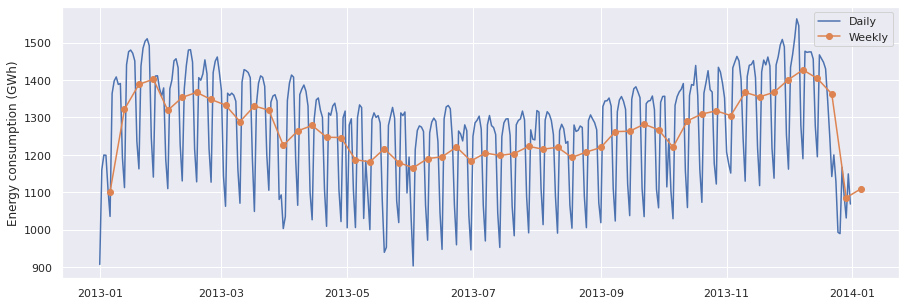

In [13]:
plt.figure(figsize=(15,5))

plt.plot(df['Consumption']['2013'], label='Daily')

plt.plot(df_consumption_2013_weekly,
         marker='o',
         label='Weekly')

plt.ylabel('Energy consumption (GWh)')
plt.legend()

What effect have we gotten by weekly downsampling?

Exercise 2.1
---

Compare (within a single plot) the monthly trends of
- electric energy consumption
- renewable energy production (solar, wind and the sum of the two).

Plot the yearly trend of the ratio between
- renewable energy production
- electric energy consumption.

Rolling windows
===

The *rolling* function is another useful Pandas tool. Like with resample, an aggregation function is required.

Let's suppose we want to analyse energy consumption records within a three-day window.

In [14]:
df['Consumption']

Date
2006-01-01    1069.18400
2006-01-02    1380.52100
2006-01-03    1442.53300
2006-01-04    1457.21700
2006-01-05    1477.13100
                 ...    
2017-12-27    1263.94091
2017-12-28    1299.86398
2017-12-29    1295.08753
2017-12-30    1215.44897
2017-12-31    1107.11488
Name: Consumption, Length: 4383, dtype: float64

We sequentially shift the window from left to right: at the first two steps, the window will only contain respectively one and two values.

In [15]:
df['Consumption'][:1]

Date
2006-01-01    1069.184
Name: Consumption, dtype: float64

In [16]:
df['Consumption'][:2]

Date
2006-01-01    1069.184
2006-01-02    1380.521
Name: Consumption, dtype: float64

At this point, the window overlaps with the first three records.

In [17]:
df['Consumption'][:3]

Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
Name: Consumption, dtype: float64

And so on.

In [18]:
df['Consumption'][1:4]

Date
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
Name: Consumption, dtype: float64

In [19]:
df['Consumption'][2:5]

Date
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
Name: Consumption, dtype: float64

Let's now aggregate, at each step, all the records lying in the window. For example, we can sum them up.

In [20]:
df['Consumption'][:1].sum()

1069.1840000000002

In [21]:
df['Consumption'][:2].sum()

2449.705000000001

In [22]:
df['Consumption'][:3].sum()

3892.2380000000007

In [23]:
df['Consumption'][1:4].sum()

4280.271000000001

In [24]:
df['Consumption'][2:5].sum()

4376.881

Once the width of the sampling window and the aggregation function have been choosen, rolling allows to perform the above operation compactly.

In [25]:
df['Consumption'].rolling('3D').sum()

Date
2006-01-01    1069.18400
2006-01-02    2449.70500
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

The width of the window can be also specified through the number of records it should be containing at each step.

In [26]:
df['Consumption'].rolling(3).sum()

Date
2006-01-01           NaN
2006-01-02           NaN
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

Doing this, however, the window discards (by default) all the groups with at least one missing value. Of course, we can alter this behaviour by means of optional arguments.

In [27]:
df['Consumption'].rolling(3, min_periods=1).sum()

Date
2006-01-01    1069.18400
2006-01-02    2449.70500
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

Here are some more examples.

In [28]:
df['Consumption'].rolling(3, center=True).sum()

Date
2006-01-01           NaN
2006-01-02    3892.23800
2006-01-03    4280.27100
2006-01-04    4376.88100
2006-01-05    4337.77500
                 ...    
2017-12-27    3693.92172
2017-12-28    3858.89242
2017-12-29    3810.40048
2017-12-30    3617.65138
2017-12-31           NaN
Name: Consumption, Length: 4383, dtype: float64

In [29]:
df['Consumption'][:7].sum()

9530.300000000001

In [30]:
df['Consumption'].rolling(7, center=True).sum()

Date
2006-01-01           NaN
2006-01-02           NaN
2006-01-03           NaN
2006-01-04    9530.30000
2006-01-05    9669.10100
                 ...    
2017-12-27    8457.49890
2017-12-28    8422.85648
2017-12-29           NaN
2017-12-30           NaN
2017-12-31           NaN
Name: Consumption, Length: 4383, dtype: float64

Let's now have a look at the graphical result yield by rolling. For the sake of convenience, we set the Matplotlib *figsize* property once and for all.

In [31]:
plt.rcParams['figure.figsize'] = (15,5)

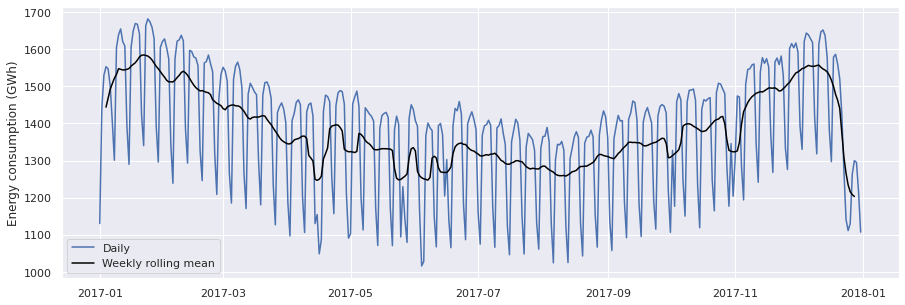

In [32]:
plt.plot(df['Consumption']['2017'],
         label='Daily')

plt.plot(df['Consumption']['2017'].rolling(7, center=True).mean(),
         label='Weekly rolling mean',
         color='black')

plt.ylabel('Energy consumption (GWh)')
plt.legend()

We have computed and represented the 2017 weekly *rolling mean* of our consumption data.

Exercise 2.2
---

Resample and rolling have common ground. How are their outcomes different?

Plot weekly solar energy production during 2017/01-07 by using resample and rolling. Compare the graphical results.

---

**Recap**: downsampling and rolling windows yield a smoothing effect on a time series. Specifically, variations happening at a frequency lower or equal to the width of the sampling window are canceled out.

Eliminating such seasonal variations allows to focus on another main component of a time series: its **trend**.

Trends
---

Let's start by picturing consumption data at a daily frequency.

Text(0.5, 1.0, 'Electric energy consumption (GWh)')

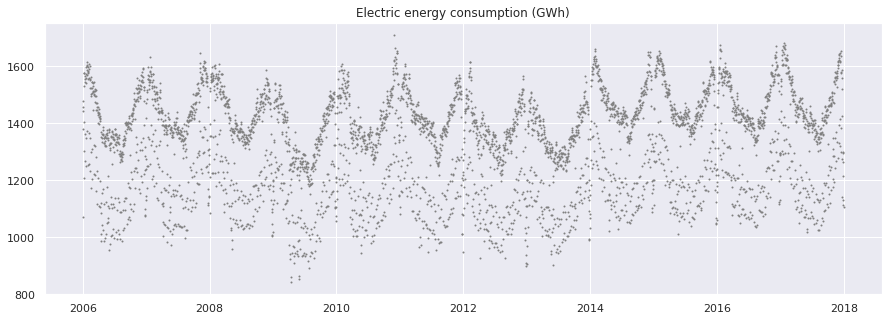

In [33]:
plt.plot(df['Consumption'],
         marker='.',
         markersize=2,
         linestyle='',
         color='gray')
plt.title('Electric energy consumption (GWh)')

As we have seen in the first lesson, Germany's electric energy consumption shows yearly and weekly seasonality.

Let's add the weekly rolling mean to the plot.

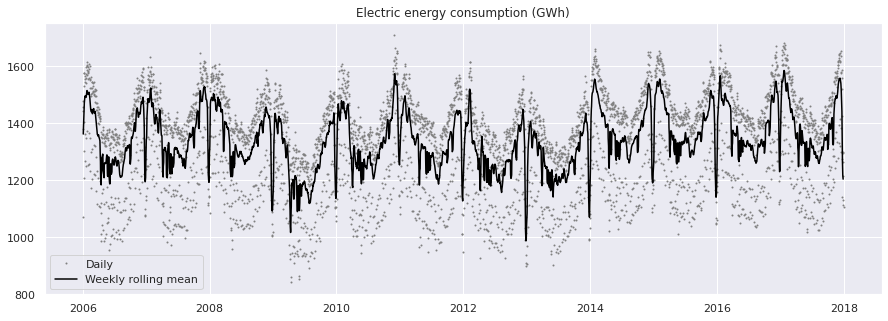

In [34]:
plt.plot(df['Consumption'],
         marker='.',
         markersize=2,
         linestyle='',
         label='Daily',
         color='gray')

plt.plot(df['Consumption'].rolling(7, center=True).mean(),
         label='Weekly rolling mean',
         color='black')

plt.title('Electric energy consumption (GWh)')
plt.legend()

As we expected, the weekly rolling mean cancels the corresponding seasonality. On the other hand yearly seasonality is highlighted, and we can observe:
- the oscillating trend caused by electric heating and increased lighting usage
- negative peaks during winter holidays.

Let's continue the analysis by adding the yearly rolling mean to our plot.

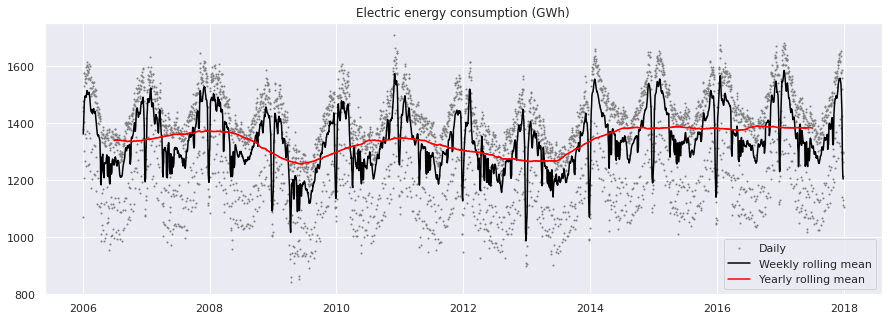

In [35]:
plt.plot(df['Consumption'],
         marker='.',
         markersize=2,
         linestyle='',
         label='Daily',
         color='gray')

plt.plot(df['Consumption'].rolling(7, center=True).mean(),
         label='Weekly rolling mean',
         color='black')

plt.plot(df['Consumption'].rolling(365, center=True).mean(),
         label='Yearly rolling mean',
         color='red')

plt.title('Electric energy consumption (GWh)')
plt.legend()

Once we get rid of a time series' seasonality, what is left is its *long-term trend*.

Well, sort of: we will get back on this later on.

Exercise 2.3
---

Analyse the trend in solar energy production starting from 2012.

Compare, starting from 2006, the trends in
- solar energy production
- wind energy production
- total production of renewable energy.

Linear, quadratic and exponential trend
---

Before moving on, let's make a brief comparison between typical trends. We will generate them synthetically by using NumPy.

In [36]:
import numpy as np

In [37]:
plt.rcParams['figure.figsize'] = (15,3)

A *linear trend* can be compared to a straight line: the rate of growth does not change over time.

In [38]:
linear_trend = np.array([5*t for t in range(50)])
linear_trend

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245])

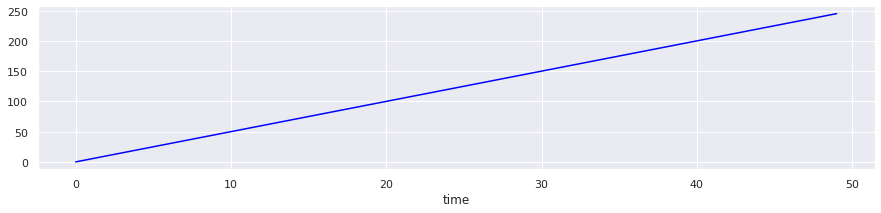

In [39]:
plt.xlabel('time')
plt.plot(linear_trend, color='blue')

A *quadratic trend* (more generally a *polynomial* one) can be compared with a curved line, and its rate of growth does change over time.

In [40]:
quadratic_trend = np.array([t**2 for t in range(50)])
quadratic_trend

array([   0,    1,    4,    9,   16,   25,   36,   49,   64,   81,  100,
        121,  144,  169,  196,  225,  256,  289,  324,  361,  400,  441,
        484,  529,  576,  625,  676,  729,  784,  841,  900,  961, 1024,
       1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849,
       1936, 2025, 2116, 2209, 2304, 2401])

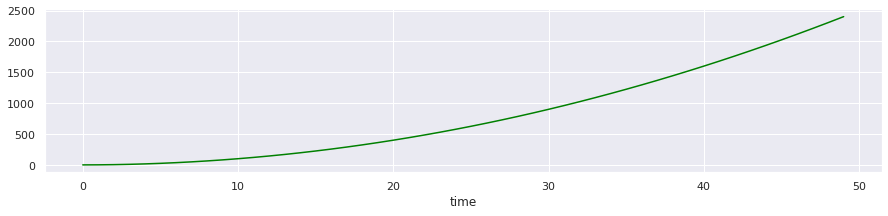

In [41]:
plt.xlabel('time')
plt.plot(quadratic_trend, color='green')

An *exponential trend* is a curved line too, but its rate of growth goes up a lot faster: time is the exponent!

In [42]:
exponential_trend = np.array([2**t for t in range(50)])
exponential_trend

array([              1,               2,               4,               8,
                    16,              32,              64,             128,
                   256,             512,            1024,            2048,
                  4096,            8192,           16384,           32768,
                 65536,          131072,          262144,          524288,
               1048576,         2097152,         4194304,         8388608,
              16777216,        33554432,        67108864,       134217728,
             268435456,       536870912,      1073741824,      2147483648,
            4294967296,      8589934592,     17179869184,     34359738368,
           68719476736,    137438953472,    274877906944,    549755813888,
         1099511627776,   2199023255552,   4398046511104,   8796093022208,
        17592186044416,  35184372088832,  70368744177664, 140737488355328,
       281474976710656, 562949953421312])

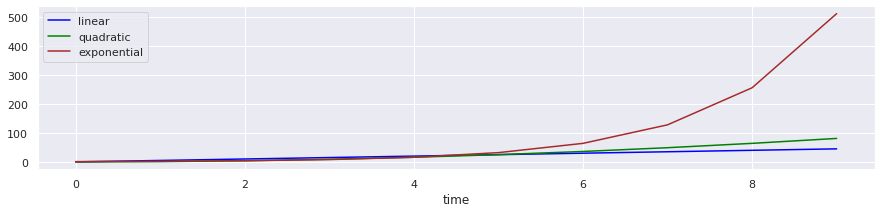

In [43]:
plt.plot(linear_trend[:10], label='linear', color='blue')
plt.plot(quadratic_trend[:10], label='quadratic', color='green')
plt.plot(exponential_trend[:10], label='exponential', color='brown')

plt.xlabel('time')
plt.legend()

**Recap**: so far we have defined and analysed two of the main components of a time series, namely its seasonality and trend(s). We have also introduced some typical example of trend.

---

Decomposition
===
Let's continue with the concept of *decomposition* of a time series.

Additive model
---

Trend and seasonality are structural, *systematic* components of a time series; that is, they can be analysed and modeled. This process is the basis of forecasting.

Another systematic component of a series is the **level**: put simply, its average value. We can think of it as a flat (zero growth) linear trend.

A general model of time series is:

<h3><center><i>LEVEL + SEASONALITY + TREND + $\epsilon.$</i></center></h3>

This is called **additive model**, as it is the sum of its terms. $\epsilon$ is called **residual**: the non-systematic component which cannot be straight modeled.

Let's build a time series component by component, starting from its level.

Text(0.5, 1.0, 'level')

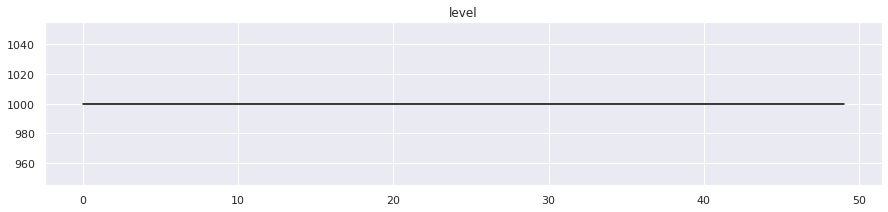

In [44]:
level = 1000*np.ones(50)

plt.plot(level, color='black')
plt.title('level')

We add the first component to our synthetic series.

Text(0.5, 1.0, 'time series')

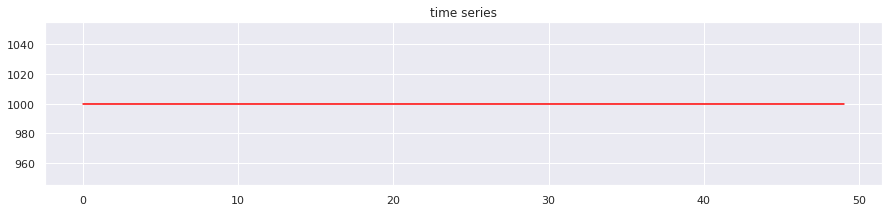

In [45]:
time_series = level

plt.plot(time_series, color='red')
plt.title('time series')

Let's move on to seasonality. We use NumPy *sin* to generate a periodic signal...

Text(0.5, 1.0, 'seasonality')

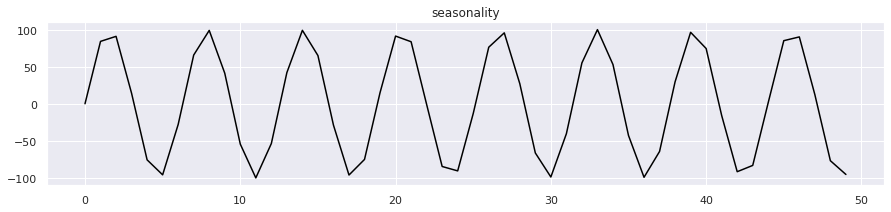

In [46]:
seasonality = 100*np.sin([i for i in range(50)])

plt.plot(seasonality, color='black')
plt.title('seasonality')

...and we add it to the series.

Text(0.5, 1.0, 'time series')

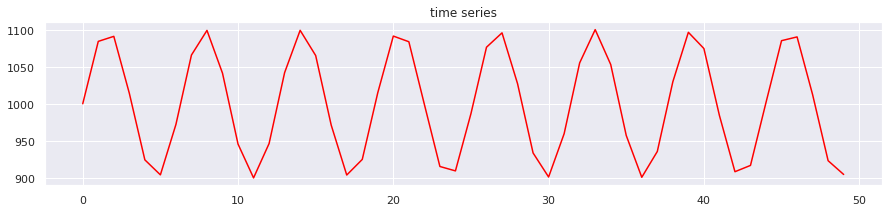

In [47]:
time_series = level + seasonality

plt.plot(time_series, color='red')
plt.title('time series')

Finally, we add an increasing trend.

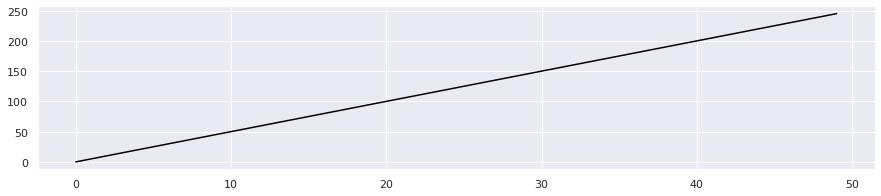

In [48]:
plt.plot(linear_trend, color='black')

Text(0.5, 1.0, 'time series')

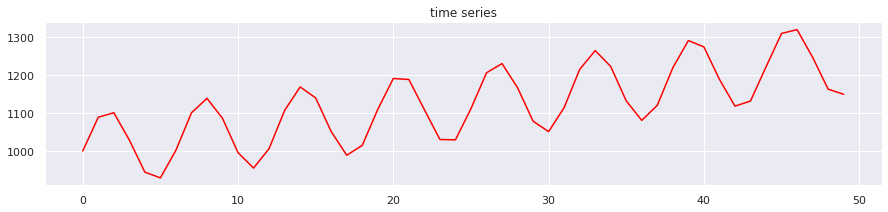

In [49]:
time_series = level + seasonality + linear_trend

plt.plot(time_series, color='red')
plt.title('time series')

Another model of time series is the **multiplicative** one, where the components are combined in a non-linear way.

In the next example, seasonality is multiplied (and hence amplified) by the increasing trend.

Text(0.5, 1.0, 'time series')

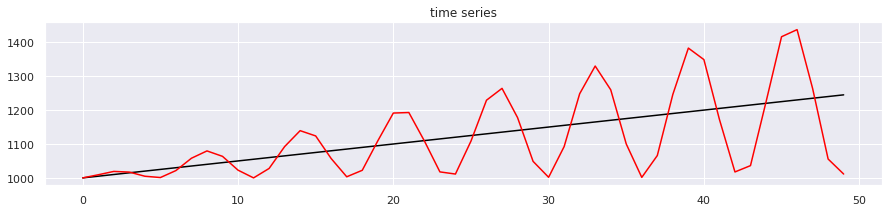

In [50]:
time_series = level + linear_trend + 0.01*linear_trend*seasonality

plt.plot(level+linear_trend, color='black')
plt.plot(time_series, color='red')
plt.title('time series')

*seasonal_decompose*
---

The *seasonal_decompose* function (*statsmodel* library) allows to decompose a series into its terms.

**Remark**: this is a naive decomposition, and there are [more sophisticated ones](https://otexts.com/fpp2/decomposition.html). 

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [52]:
decomposition = seasonal_decompose(df['Consumption']['2015-01':'2015-06'])

The returned object contains a Pandas series for each of the components.

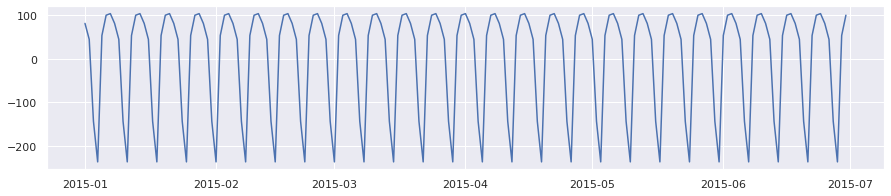

In [53]:
plt.figure(figsize=(15,3))
plt.plot(decomposition.seasonal)

We can also represent all the components in a single plot.

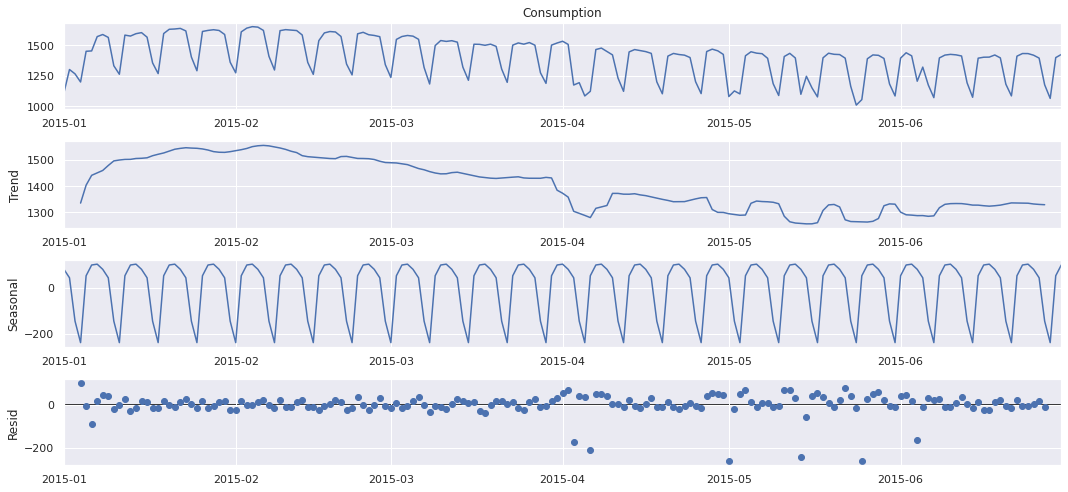

In [54]:
plt.rcParams['figure.figsize'] = (15,7)
plot = decomposition.plot()#evita plot doppi

**Recap**: an additive time series is the sum of its systematic components (level, trend, seasonality) plus a residual term. In a multiplicative model these components are combined in a non-linear way.

---

Forecast
===
The analysis of a time series is basic to predict its feature.

Forecasting is a hard process, requiring technical, scientific and business skills. There are many predictive models out there, each one coming with its theoretical intuition and a number of parameters to be tuned.

Facebook Prophet
---
**Prophet** is a forecasting procedure released by Facebook in 2017. Here are some of the features which make it a powerful and versatile tool:

- it is able to handle multiple seasonality and abrupt trend changes
- it is robust to missing data and outliers
- it is fairly out-of-the-box, while at the same time highly customizable.

Let's have a look.

We import the library (and silence Pandas warnings).

In [57]:
import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet

We want to predict the electric consumption of 2017, given data from the past.

In [58]:
df = pd.read_csv('../data/OPSD_Germany_consumption.csv',
                 parse_dates=True,
                 index_col='Date')

df.head()

,Consumption
Date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131


We split the dataframe into a training and test set.

In [59]:
df_train = df['2006':'2016']
df_test = df['2017']

In [60]:
df_train

,Consumption
Date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131
...,...
2016-12-27,1289.324
2016-12-28,1294.881
2016-12-29,1295.897


In [61]:
df_test

,Consumption
Date,
2017-01-01,1130.41300
2017-01-02,1441.05200
2017-01-03,1529.99000
2017-01-04,1553.08300
2017-01-05,1547.23800
...,...
2017-12-27,1263.94091
2017-12-28,1299.86398
2017-12-29,1295.08753


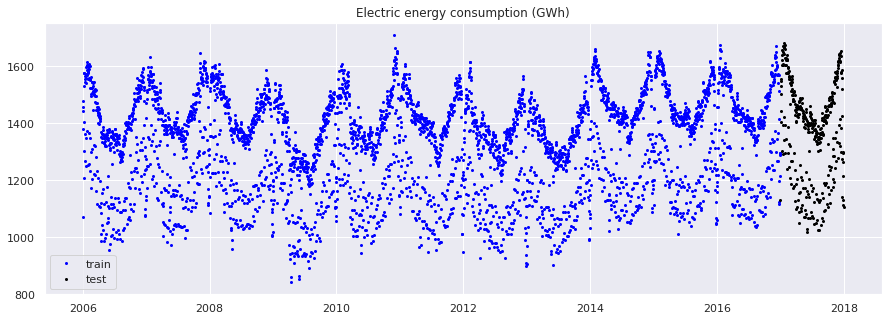

In [62]:
plt.figure(figsize=(15, 5))

plt.plot(df_train,
         marker='.',
         markersize=4,
         linestyle='',
         label='train',
         color='blue')

plt.plot(df_test,
         marker='.',
         markersize=4,
         linestyle='',
         label='test',
         color='black')

plt.title('Electric energy consumption (GWh)')
plt.legend()

Prophet easily works with dataframes, though it requires a specific structure. We need two columns:
- *ds* for the temporal index
- *y*  for the numerical values of the series.

We build the dataframe to pass to Prophet. We use Pandas *reset_index* to turn the temporal index into a standard column.

In [63]:
df_train_prophet = df_train.reset_index()
df_train_prophet

,Date,Consumption
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131
...,...,...
4013,2016-12-27,1289.324
4014,2016-12-28,1294.881
4015,2016-12-29,1295.897
4016,2016-12-30,1291.044


We rename the columns as required.

In [64]:
df_train_prophet.columns = ['ds', 'y']
df_train_prophet

,ds,y
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131
...,...,...
4013,2016-12-27,1289.324
4014,2016-12-28,1294.881
4015,2016-12-29,1295.897
4016,2016-12-30,1291.044


We are finally ready for training. Prophet's syntax is similar to that of Scikit-learn.

In [65]:
model = Prophet()
model.fit(df_train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Let's build the data structure that will contain test predictions.

In [66]:
future = model.make_future_dataframe(periods=365, include_history=False)
future

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05
...,...
360,2017-12-27
361,2017-12-28
362,2017-12-29
363,2017-12-30


We pass the structure we just built to the *predict* function of the trained Prophet model.

In [67]:
test_predictions = model.predict(future)

A dataframe is returned, containing several columns. The *yhat* column stores the numerical test predictions.

In [68]:
test_predictions.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [69]:
test_predictions['yhat']

0      1070.423451
1      1366.566322
2      1415.499839
3      1431.904684
4      1432.507212
          ...     
360    1385.077167
361    1370.679951
362    1344.395549
363    1153.774646
364    1060.686284
Name: yhat, Length: 365, dtype: float64

We add these predictions to the test set's dataframe.

In [70]:
df_test['Prediction'] = test_predictions['yhat'].values
df_test

,Consumption,Prediction
Date,,
2017-01-01,1130.41300,1070.423451
2017-01-02,1441.05200,1366.566322
2017-01-03,1529.99000,1415.499839
2017-01-04,1553.08300,1431.904684
2017-01-05,1547.23800,1432.507212
...,...,...
2017-12-27,1263.94091,1385.077167
2017-12-28,1299.86398,1370.679951
2017-12-29,1295.08753,1344.395549


Let's compare the actual (test) consumption with that predicted by Prophet.

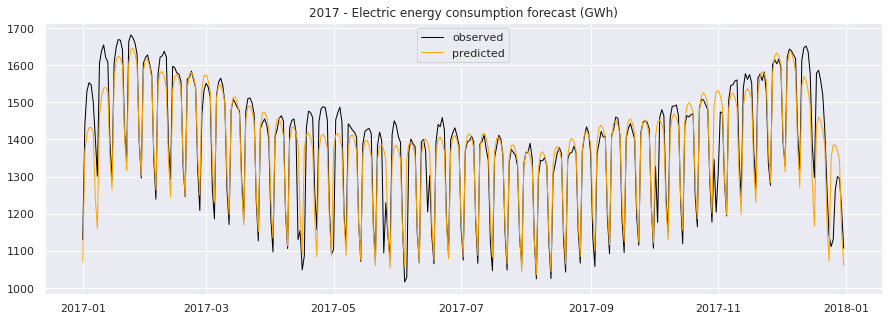

In [71]:
plt.figure(figsize=(15, 5))

plt.plot(df_test['Consumption'],
         linestyle='-',
         color='black',
         linewidth=1,
         label='observed')

plt.plot(df_test['Prediction'],
         linestyle='-',
         linewidth=1,
         color='orange',
         label='predicted')

plt.title('2017 - Electric energy consumption forecast (GWh)')
plt.legend()

**Recap**: so far, we have
- split data into training and test set
- created the data structure required by Prophet for training and making predictions
- trained a model on the training set
- obtained test predictions
- compared actual and predicted values.

Are we happy enough? What's next?

Like with standard supervised learning, we need to *quantitatively* evaluate our predictions. We therefore need a **metric** to quantify the error made by the trained model. [Here](https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python) you can find a nice discussion on how to measure forecasting performance.

A training model has several **hyperparameters** to be tuned, influencing the degree of fitting of training data. In Scikit-learn, these are implemented as arguments to be passed to the model at construction time. The same goes for Prophet.

Among them, we find *changepoint_prior_scale*. A [*changepoint*](https://facebook.github.io/prophet/docs/trend_changepoints.html) is a time instant at which the series abruptly changes its behaviour. By fine-tuning this hyperparameter, we set the model sensitivity to changepoints:

<br>

<img src='../img/changepoints.png' width=400/>

<br>

Seasonality can be looked for or excluded from the model by setting the *daily_*, *weekly_* and *yearly_seasonality* arguments.

The graphical example of this cell is taken from [here](https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a), while [this](https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274) is another useful resource.

Exercise 2.4
---
Forecast and represent the solar energy production of 2017, by using years from 2012 to 2016 as training data.

---

Going deeper
===

Time series are a rich and complex topic. Here are some extra resources.

**Python tools**:
- https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html.

**Stationarity**:
- https://people.duke.edu/~rnau/411diff.htm
- https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/.

**Autocorrelation**:
- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
- https://www.youtube.com/watch?v=ZjaBn93YPWo.

**Forecast models**:

- https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
- https://www.youtube.com/watch?v=d4Sn6ny_5LI
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/.

**Forecast and supervised learning**:
- https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
- https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/.

**Datasets and notebooks**:
- https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
- https://machinelearningmastery.com/time-series-datasets-for-machine-learning/
- https://www.kaggle.com/search?q=time+series.

---

<script>
  $(document).ready(function(){
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('div.prompt').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter, delivered by Fastly, rendered by OVHCloud.
</footer>